In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
%load_ext tensorboard

In [2]:
x_train = np.load("dataset/x_train.npy")/255.
x_test = np.load("dataset/x_test.npy")/255.
y_train_coarse = np.load("dataset/y_train_coarse.npy")
y_train_fine = np.load("dataset/y_train_fine.npy")

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import pickle
with open("dataset/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("dataset/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)

In [5]:
y_train = np.vstack([y_train_fine, y_train_coarse]).T

In [6]:
y_train.shape

(50000, 2)

In [7]:
x_train.shape

(50000, 32, 32, 3)

In [8]:
x_train,x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train)

In [9]:
y_val.shape

(5000, 2)

In [10]:
x_val.shape

(5000, 32, 32, 3)

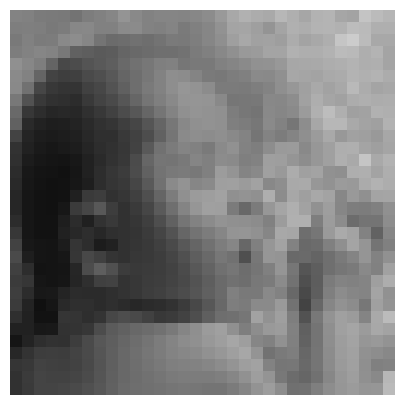

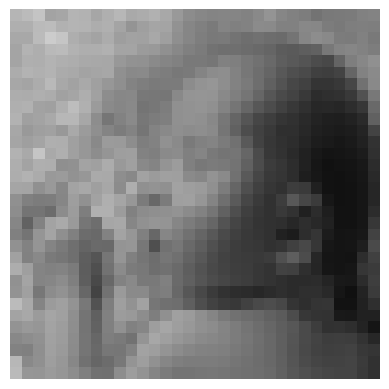

In [11]:
x_train_bis = x_train[:,:,::-1,:]
ex_idx = -1
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(x_train_bis[ex_idx])
plt.show()
plt.axis('off') 
plt.imshow(x_train[ex_idx])
plt.show()

In [12]:
labels_fine[y_train[ex_idx][0]]

'baby'

In [13]:
x_train_dup = np.concatenate([x_train, x_train_bis],axis=0)
y_train_dup = np.concatenate([y_train, y_train], axis=0)
x_train_bis = x_train_dup.copy()
x_train_bis_bis = x_train_dup.copy()
x_train_bis[:,:,1:,:] =x_train_dup[:,:,:-1,:]
x_train_bis_bis[:,:,:-1,:] =x_train_dup[:,:,1:,:]
x_train_dup = np.concatenate([x_train_dup, x_train_bis, x_train_bis_bis],axis=0)
y_train_dup = np.concatenate([y_train_dup, y_train_dup, y_train_dup], axis=0)


In [14]:
x_train_dup.shape, y_train_dup.shape

((270000, 32, 32, 3), (270000, 2))

In [15]:
# Me fijo para una categoría de grano grueso, cuáles son las categorías de grano fino
coarse = 10
print(f"Grano grueso: {labels_coarse[coarse]}")
for fine in np.unique(y_train_fine[y_train_coarse == coarse]):
    print(f"Grano fino: {labels_fine[fine]}")

Grano grueso: large_natural_outdoor_scenes
Grano fino: cloud
Grano fino: forest
Grano fino: mountain
Grano fino: plain
Grano fino: sea


In [16]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import models

In [23]:

# Define model architecture
def create_model(input_shape=(32, 32, 3), l2_lambda=0.001):
    # Input layer for images
    inputs = layers.Input(shape=input_shape)
    
    # Flattening layer
    x = layers.Flatten()(inputs)
    
    # Dense layers with L2 regularization
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
    # Parallel output layers
    fine_output = layers.Dense(100, activation='softmax', name='fine_output')(x)   # Fine-grain prediction
    coarse_output = layers.Dense(20, activation='softmax', name='coarse_output')(x) # Coarse-grain prediction
    
    # Create model
    model = models.Model(inputs=inputs, outputs=[fine_output, coarse_output])
    
    return model



In [24]:
# Instantiate the model
model = create_model()

# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'fine_output': 'sparse_categorical_crossentropy', 
        'coarse_output': 'sparse_categorical_crossentropy'
    },
    #metrics=['accuracy','accuracy']
    metrics={
        'fine_output': 'accuracy'  # Apply accuracy metric only to the fine output
    }
)

# Early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,verbose= 1)

rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-5
)
tb = TensorBoard(
    log_dir="logs",
)
# Display the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3072)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │  1,573,376 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    131,328 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │      8,320 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │     33,024 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │    131,584 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fine_output (Dense) │ (None, 100)       │     51,300 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coarse_output       │ (None, 20)        │     10,260 │ dense_8[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,980,344 (7.55 MB)

 Trainable params: 1,980,344 (7.55 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Fit the model
history = model.fit(
    x=x_train_dup,                          # Input data (images)
    y={'fine_output': y_train_dup[:,1],     # Fine labels target output
       'coarse_output': y_train_dup[:,0]},# Coarse labels target output
    validation_data=(x_val, {'fine_output': y_val[:,1], 'coarse_output': y_val[:,0]}),
    epochs=50,                          # Set your number of epochs
    batch_size=50,                      # Batch size (tune as needed)
    #callbacks=[tb, early_stopping]     
    callbacks=[tb]   # TensorBoard and early stopping callbacks
)

Epoch 1/50
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 93s 17ms/step - coarse_output_loss: 2.6728 - fine_output_accuracy: 0.0073 - fine_output_loss: 4.1439 - loss: 7.0807 - val_coarse_output_loss: 2.4302 - val_fine_output_accuracy: 0.0092 - val_fine_output_loss: 3.7607 - val_loss: 6.3430
Epoch 2/50
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 92s 17ms/step - coarse_output_loss: 2.3951 - fine_output_accuracy: 0.0108 - fine_output_loss: 3.6974 - loss: 6.2513 - val_coarse_output_loss: 2.3264 - val_fine_output_accuracy: 0.0094 - val_fine_output_loss: 3.6016 - val_loss: 6.1049
Epoch 3/50
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 87s 16ms/step - coarse_output_loss: 2.3127 - fine_output_accuracy: 0.0107 - fine_output_loss: 3.5516 - loss: 6.0456 - val_coarse_output_loss: 2.2955 - val_fine_output_accuracy: 0.0134 - val_fine_output_loss: 3.5545 - val_loss: 6.0443
Epoch 4/50
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 85s 16ms/step - coarse_output_loss: 2.2604 - fine_output_accuracy: 0.0128 - fine_output_loss: 3.4594 - loss: 5.9194 - val_coarse_o

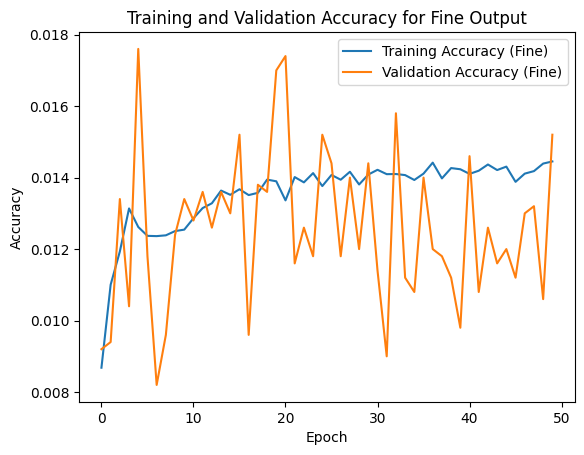

In [26]:
# Plot training & validation accuracy for the fine output
plt.plot(history.history['fine_output_accuracy'], label='Training Accuracy (Fine)')
plt.plot(history.history['val_fine_output_accuracy'], label='Validation Accuracy (Fine)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Fine Output')
plt.legend()
plt.show()

-------------------------------------------------


# modelo con chiches 



In [17]:
from tensorflow.keras import layers, models, regularizers, constraints


In [19]:
# Define model architecture with optimized fully connected layers
def create_model2(input_shape=(32, 32, 3), l2_lambda=0.001, dropout_rate=0.3):
    # Input layer for images
    inputs = layers.Input(shape=input_shape)
    
    # Flattening layer
    x = layers.Flatten()(inputs)
    
    # Dense layers with Batch Normalization, Dropout, L2 regularization, and Max-Norm constraint
    x = layers.Dense(1024, activation='relu', 
                     kernel_regularizer=regularizers.l2(l2_lambda),
                     kernel_constraint=constraints.MaxNorm(3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Dense(512, activation='relu', 
                     kernel_regularizer=regularizers.l2(l2_lambda),
                     kernel_constraint=constraints.MaxNorm(3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Dense(256, activation='relu', 
                     kernel_regularizer=regularizers.l2(l2_lambda),
                     kernel_constraint=constraints.MaxNorm(3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # Parallel output layers for fine and coarse predictions
    fine_output = layers.Dense(100, activation='softmax', name='fine_output')(x)   # Fine-grain prediction
    coarse_output = layers.Dense(20, activation='softmax', name='coarse_output')(x) # Coarse-grain prediction
    
    # Create model
    model = models.Model(inputs=inputs, outputs=[fine_output, coarse_output])
    
    return model

In [20]:
# Instantiate the model
model = create_model2()

# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'fine_output': 'sparse_categorical_crossentropy', 
        'coarse_output': 'sparse_categorical_crossentropy'
    },
    #metrics=['accuracy','accuracy']
    metrics={
        'fine_output': 'accuracy'  # Apply accuracy metric only to the fine output
    }
)

# Early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,verbose= 1)

rlrop = ReduceLROnPlateau(
    monitor="val_fine_output_accuracy",  # Monitor fine output validation accuracy
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-5
)
tb = TensorBoard(
    log_dir="logs",
)
# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3072)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  3,146,752 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fine_output (Dense) │ (None, 100)       │     25,700 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coarse_output       │ (None, 20)        │      5,140 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,840,888 (14.65 MB)

 Trainable params: 3,837,304 (14.64 MB)

 Non-trainable params: 3,584 (14.00 KB)

# Modelo many layers chicos 

In [21]:
# Define model architecture with many small dense layers and PReLU activation
def create_model3(input_shape=(32, 32, 3)):
    # Input layer for images
    inputs = layers.Input(shape=input_shape)
    
    # Flattening layer to convert 3D input to 1D
    x = layers.Flatten()(inputs)
    
    # Many small dense layers with PReLU activation
    x = layers.Dense(128)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(128)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(64)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(64)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(64)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(32)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(32)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(32)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(16)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(16)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(16)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(8)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(8)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(8)(x)
    x = layers.PReLU()(x)
    
    # Parallel output layers for fine and coarse predictions
    fine_output = layers.Dense(100, activation='softmax', name='fine_output')(x)   # Fine-grain prediction
    coarse_output = layers.Dense(20, activation='softmax', name='coarse_output')(x) # Coarse-grain prediction
    
    # Create model
    model = models.Model(inputs=inputs, outputs=[fine_output, coarse_output])
    
    return model

In [22]:
# Instantiate the model
model3 = create_model3()

# Compile the model
model3.compile(
    optimizer='adam',
    loss={
        'fine_output': 'sparse_categorical_crossentropy', 
        'coarse_output': 'sparse_categorical_crossentropy'
    },
    #metrics=['accuracy','accuracy']
    metrics={
        'fine_output': 'accuracy'  # Apply accuracy metric only to the fine output
    }
)

# Early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,verbose= 1)

rlrop = ReduceLROnPlateau(
    monitor="val_fine_output_accuracy",  # Monitor fine output validation accuracy
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-5
)
tb = TensorBoard(
    log_dir="logs",
)
# Display the model summary
model3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3072)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │    393,344 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 128)       │        128 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     16,512 │ p_re_lu[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 128)       │        128 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ p_re_lu_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 64)        │         64 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      4,160 │ p_re_lu_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_3 (PReLU)   │ (None, 64)        │         64 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      4,160 │ p_re_lu_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_4 (PReLU)   │ (None, 64)        │         64 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      2,080 │ p_re_lu_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_5 (PReLU)   │ (None, 32)        │         32 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      1,056 │ p_re_lu_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_6 (PReLU)   │ (None, 32)        │         32 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      1,056 │ p_re_lu_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_7 (PReLU)   │ (None, 32)        │         32 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 16)        │        528 │ p_re_lu_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_8 (PReLU)   │ (None, 16)        │         16 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 16)        │        272 │ p_re_lu_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_9 (PReLU)   │ (None, 16)        │         16 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 16)        │        272 │ p_re_lu_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_10 (PReLU)  │ (None, 16)        │         16 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 433,672 (1.65 MB)

 Trainable params: 433,672 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Fit the model
history3 = model3.fit(
    x=x_train_dup,                          # Input data (images)
    y={'fine_output': y_train_dup[:,1],     # Fine labels target output
       'coarse_output': y_train_dup[:,0]},# Coarse labels target output
    validation_data=(x_val, {'fine_output': y_val[:,1], 'coarse_output': y_val[:,0]}),
    epochs=25,                          # Set your number of epochs
    batch_size=50,                      # Batch size (tune as needed)
    #callbacks=[tb, early_stopping]     
    callbacks=[tb]   # TensorBoard and early stopping callbacks
)

Epoch 1/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - coarse_output_loss: 2.7917 - fine_output_accuracy: 0.0087 - fine_output_loss: 4.3587 - loss: 7.1505 - val_coarse_output_loss: 2.6403 - val_fine_output_accuracy: 0.0114 - val_fine_output_loss: 4.1409 - val_loss: 6.7812
Epoch 2/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - coarse_output_loss: 2.6237 - fine_output_accuracy: 0.0084 - fine_output_loss: 4.1214 - loss: 6.7451 - val_coarse_output_loss: 2.5138 - val_fine_output_accuracy: 0.0092 - val_fine_output_loss: 3.9894 - val_loss: 6.5033
Epoch 3/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - coarse_output_loss: 2.5189 - fine_output_accuracy: 0.0100 - fine_output_loss: 3.9763 - loss: 6.4952 - val_coarse_output_loss: 2.4900 - val_fine_output_accuracy: 0.0062 - val_fine_output_loss: 3.9183 - val_loss: 6.4082
Epoch 4/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - coarse_output_loss: 2.4494 - fine_output_accuracy: 0.0096 - fine_output_loss: 3.8693 - loss: 6.3187 - val_coarse_outpu

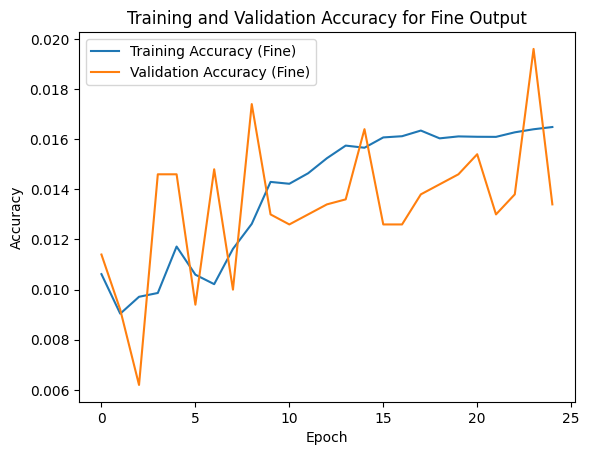

In [24]:
# Plot training & validation accuracy for the fine output
plt.plot(history3.history['fine_output_accuracy'], label='Training Accuracy (Fine)')
plt.plot(history3.history['val_fine_output_accuracy'], label='Validation Accuracy (Fine)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Fine Output')
plt.legend()
plt.show()

### sigo train


In [38]:
# Save the model after 25 epochs
model3.save("model_checkpoint.keras")

In [39]:
from tensorflow.keras.models import load_model

In [40]:

# Load the model
trained_model_3 = load_model("model_checkpoint.keras")

# Continue training for additional epochs
additional_epochs = 25


history3_additional = trained_model_3.fit(
    x=x_train_dup,                           # Input data
    y={'fine_output': y_train_dup[:, 1],     # Fine labels target output
       'coarse_output': y_train_dup[:, 0]},  # Coarse labels target output
    validation_data=(x_val, {'fine_output': y_val[:, 1], 'coarse_output': y_val[:, 0]}),
    epochs=additional_epochs,
    batch_size=50,                           # Same batch size as before
    callbacks=[tb]                           # Same callbacks as before
)

c:\Users\Usuario\miniconda3\envs\Redes_neuro\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - coarse_output_loss: 1.7041 - fine_output_accuracy: 0.0176 - fine_output_loss: 2.9080 - loss: 4.6121 - val_coarse_output_loss: 2.3953 - val_fine_output_accuracy: 0.0144 - val_fine_output_loss: 3.7245 - val_loss: 6.1198
Epoch 2/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - coarse_output_loss: 1.6986 - fine_output_accuracy: 0.0166 - fine_output_loss: 2.9118 - loss: 4.6104 - val_coarse_output_loss: 2.4105 - val_fine_output_accuracy: 0.0140 - val_fine_output_loss: 3.7448 - val_loss: 6.1552
Epoch 3/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - coarse_output_loss: 1.6971 - fine_output_accuracy: 0.0170 - fine_output_loss: 2.9162 - loss: 4.6133 - val_coarse_output_loss: 2.4300 - val_fine_output_accuracy: 0.0074 - val_fine_output_loss: 3.7633 - val_loss: 6.1932
Epoch 4/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - coarse_output_loss: 1.6896 - fine_output_accuracy: 0.0161 - fine_output_loss: 2.9108 - loss: 4.6004 - val_coarse_outpu

#### plot 2 history

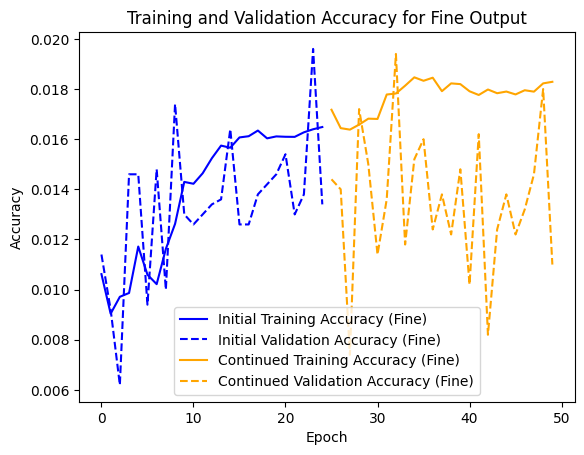

In [41]:
# Plot original training & validation accuracy for the fine output
plt.plot(history3.history['fine_output_accuracy'], label='Initial Training Accuracy (Fine)', color='blue')
plt.plot(history3.history['val_fine_output_accuracy'], label='Initial Validation Accuracy (Fine)', color='blue', linestyle='--')

# Plot continued training & validation accuracy for the fine output
# Offset x-axis to continue after the initial training epochs
initial_epochs = len(history3.history['fine_output_accuracy'])
additional_epochs = range(initial_epochs, initial_epochs + len(history3_additional.history['fine_output_accuracy']))
plt.plot(additional_epochs, history3_additional.history['fine_output_accuracy'], label='Continued Training Accuracy (Fine)', color='orange')
plt.plot(additional_epochs, history3_additional.history['val_fine_output_accuracy'], label='Continued Validation Accuracy (Fine)', color='orange', linestyle='--')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Fine Output')
plt.legend()
plt.show()

In [42]:
trained_model_3.save("model_checkpoint.keras")

### 3 train 

In [50]:
# Load the model
trained_2_model_3 = load_model("model_checkpoint.keras")

# Continue training for additional epochs
additional_epochs = 200


history3_additional_2 = trained_2_model_3.fit(
    x=x_train_dup,                           # Input data
    y={'fine_output': y_train_dup[:, 1],     # Fine labels target output
       'coarse_output': y_train_dup[:, 0]},  # Coarse labels target output
    validation_data=(x_val, {'fine_output': y_val[:, 1], 'coarse_output': y_val[:, 0]}),
    epochs=additional_epochs,
    batch_size=50,                           # Same batch size as before
    callbacks=[tb]                           # Same callbacks as before
)

Epoch 1/200
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - coarse_output_loss: 1.5177 - fine_output_accuracy: 0.0184 - fine_output_loss: 2.7379 - loss: 4.2556 - val_coarse_output_loss: 2.7558 - val_fine_output_accuracy: 0.0146 - val_fine_output_loss: 4.1209 - val_loss: 6.8767
Epoch 2/200
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - coarse_output_loss: 1.5155 - fine_output_accuracy: 0.0178 - fine_output_loss: 2.7359 - loss: 4.2514 - val_coarse_output_loss: 2.7873 - val_fine_output_accuracy: 0.0094 - val_fine_output_loss: 4.1519 - val_loss: 6.9392
Epoch 3/200
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - coarse_output_loss: 1.5082 - fine_output_accuracy: 0.0179 - fine_output_loss: 2.7277 - loss: 4.2359 - val_coarse_output_loss: 2.8080 - val_fine_output_accuracy: 0.0100 - val_fine_output_loss: 4.2106 - val_loss: 7.0186
Epoch 4/200
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - coarse_output_loss: 1.4979 - fine_output_accuracy: 0.0177 - fine_output_loss: 2.7168 - loss: 4.2147 - val_coarse_o

KeyboardInterrupt: 

In [ ]:
# Plot original training & validation accuracy for the fine output
plt.plot(history3.history['fine_output_accuracy'], label='Initial Training Accuracy (Fine)', color='blue')
plt.plot(history3.history['val_fine_output_accuracy'], label='Initial Validation Accuracy (Fine)', color='blue', linestyle='--')

# Plot continued training & validation accuracy for the fine output
# Offset x-axis to continue after the initial training epochs
initial_epochs = len(history3.history['fine_output_accuracy'])
additional_epochs = range(initial_epochs, initial_epochs + len(history3_additional.history['fine_output_accuracy']))

plt.plot(additional_epochs, history3_additional.history['fine_output_accuracy'], label='Continued Training Accuracy (Fine)', color='orange')
plt.plot(additional_epochs, history3_additional.history['val_fine_output_accuracy'], label='Continued Validation Accuracy (Fine)', color='orange', linestyle='--')

# Plot for the new training history (history3_additional_2)
# Offset x-axis again for the second continuation
new_initial_epochs = initial_epochs + len(history3_additional.history['fine_output_accuracy'])
new_additional_epochs = range(new_initial_epochs, new_initial_epochs + len(history3_additional_2.history['fine_output_accuracy']))

plt.plot(new_additional_epochs, history3_additional_2.history['fine_output_accuracy'], label='Further Continued Training Accuracy (Fine)', color='green')
plt.plot(new_additional_epochs, history3_additional_2.history['val_fine_output_accuracy'], label='Further Continued Validation Accuracy (Fine)', color='green', linestyle='--')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Fine Output')
plt.legend()
plt.show()

# Model many layers big

#### GPU 

In [47]:
import tensorflow as tf

In [48]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

In [43]:

# Define model architecture with 100 dense layers, grouped in descending powers of 2
def create_model4(input_shape=(32, 32, 3)):
    # Input layer for images
    inputs = layers.Input(shape=input_shape)
    
    # Flattening layer to convert 3D input to 1D
    x = layers.Flatten()(inputs)
    
    # List of neuron counts that are powers of 2 from 2048 to 8
    neuron_counts = [2048, 1024, 512, 256, 128, 64, 32, 16, 8]
    
    # Calculate number of layers per neuron count
    layers_per_count = 100 // len(neuron_counts)  # approximately 11 layers per neuron count
    
    # Build dense layers in groups, each with the same neuron count
    for neurons in neuron_counts:
        for _ in range(layers_per_count):
            x = layers.Dense(neurons)(x)
            x = layers.PReLU()(x)
    
    # Parallel output layers for fine and coarse predictions
    fine_output = layers.Dense(100, activation='softmax', name='fine_output')(x)   # Fine-grain prediction
    coarse_output = layers.Dense(20, activation='softmax', name='coarse_output')(x) # Coarse-grain prediction
    
    # Create model
    model = models.Model(inputs=inputs, outputs=[fine_output, coarse_output])
    
    return model

In [44]:
# Instantiate the model
model4 = create_model4()

# Compile the model
model4.compile(
    optimizer='adam',
    loss={
        'fine_output': 'sparse_categorical_crossentropy', 
        'coarse_output': 'sparse_categorical_crossentropy'
    },
    #metrics=['accuracy','accuracy']
    metrics={
        'fine_output': 'accuracy'  # Apply accuracy metric only to the fine output
    }
)

# Early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,verbose= 1)

rlrop = ReduceLROnPlateau(
    monitor="val_fine_output_accuracy",  # Monitor fine output validation accuracy
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-5
)
tb = TensorBoard(
    log_dir="logs",
)
# Display the model summary
model4.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 3072)      │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_330 (Dense)   │ (None, 2048)      │  6,293,504 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_327 (PReLU) │ (None, 2048)      │      2,048 │ dense_330[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_331 (Dense)   │ (None, 2048)      │  4,196,352 │ p_re_lu_327[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_328 (PReLU) │ (None, 2048)      │      2,048 │ dense_331[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_332 (Dense)   │ (None, 2048)      │  4,196,352 │ p_re_lu_328[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_329 (PReLU) │ (None, 2048)      │      2,048 │ dense_332[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_333 (Dense)   │ (None, 2048)      │  4,196,352 │ p_re_lu_329[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_330 (PReLU) │ (None, 2048)      │      2,048 │ dense_333[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_334 (Dense)   │ (None, 2048)      │  4,196,352 │ p_re_lu_330[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_331 (PReLU) │ (None, 2048)      │      2,048 │ dense_334[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_335 (Dense)   │ (None, 2048)      │  4,196,352 │ p_re_lu_331[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_332 (PReLU) │ (None, 2048)      │      2,048 │ dense_335[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_336 (Dense)   │ (None, 2048)      │  4,196,352 │ p_re_lu_332[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_333 (PReLU) │ (None, 2048)      │      2,048 │ dense_336[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_337 (Dense)   │ (None, 2048)      │  4,196,352 │ p_re_lu_333[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_334 (PReLU) │ (None, 2048)      │      2,048 │ dense_337[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_338 (Dense)   │ (None, 2048)      │  4,196,352 │ p_re_lu_334[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_335 (PReLU) │ (None, 2048)      │      2,048 │ dense_338[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_339 (Dense)   │ (None, 2048)      │  4,196,352 │ p_re_lu_335[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_336 (PReLU) │ (None, 2048)      │      2,048 │ dense_339[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_340 (Dense)   │ (None, 2048)      │  4,196,352 │ p_re_lu_336[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_337 (PReLU) │ (None, 2048)      │      2,048 │ dense_340[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 65,102,472 (248.35 MB)

 Trainable params: 65,102,472 (248.35 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Fit the model
history4 = model4.fit(
    x=x_train_dup,                          # Input data (images)
    y={'fine_output': y_train_dup[:,1],     # Fine labels target output
       'coarse_output': y_train_dup[:,0]},# Coarse labels target output
    validation_data=(x_val, {'fine_output': y_val[:,1], 'coarse_output': y_val[:,0]}),
    epochs=5,                          # Set your number of epochs
    batch_size=50,                      # Batch size (tune as needed)
    #callbacks=[tb, early_stopping]     
    callbacks=[tb]   # TensorBoard and early stopping callbacks
)

Epoch 1/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 2387s 442ms/step - coarse_output_loss: 2.9959 - fine_output_accuracy: 9.7400e-04 - fine_output_loss: 4.6056 - loss: 7.6015 - val_coarse_output_loss: 2.9958 - val_fine_output_accuracy: 0.0500 - val_fine_output_loss: 4.6053 - val_loss: 7.6011
Epoch 2/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 2297s 425ms/step - coarse_output_loss: 2.9959 - fine_output_accuracy: 0.0093 - fine_output_loss: 4.6056 - loss: 7.6015 - val_coarse_output_loss: 2.9958 - val_fine_output_accuracy: 0.0500 - val_fine_output_loss: 4.6054 - val_loss: 7.6012
Epoch 3/5
2815/5400 ━━━━━━━━━━━━━━━━━━━━ 18:18 425ms/step - coarse_output_loss: 2.9958 - fine_output_accuracy: 0.0204 - fine_output_loss: 4.6055 - loss: 7.6013

KeyboardInterrupt: 

In [ ]:
# Plot training & validation accuracy for the fine output
plt.plot(history4.history['fine_output_accuracy'], label='Training Accuracy (Fine)')
plt.plot(history4.history['val_fine_output_accuracy'], label='Validation Accuracy (Fine)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Fine Output')
plt.legend()
plt.show()

In [ ]:
model4.save("model4_100_layers_checkpoint.keras")